# КЛАСТЕРИЗАЦИЯ

In [1]:
# загрузка библиотек
import pandas as pd
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import *
from matplotlib import pyplot as plt
from matplotlib import rc
import numpy as np
from sklearn.cluster import KMeans
#данная строчка нужна для корректного отображения графиков
%matplotlib inline

In [2]:
#загрузка базы
data = pd.read_csv('insurance.csv')
data.head()

,age,bmi,children,charges
0,19,27.900,0,16884.92400
1,18,33.770,1,1725.55230
2,28,33.000,3,4449.46200
3,33,22.705,0,21984.47061
4,32,28.880,0,3866.85520


In [3]:
#наличие корреляций между значениями
data.corr()

,age,bmi,children,charges
age,1.000000,0.109272,0.042469,0.299008
bmi,0.109272,1.000000,0.012759,0.198341
children,0.042469,0.012759,1.000000,0.067998
charges,0.299008,0.198341,0.067998,1.000000


Введите первое значение: age
Введите второе значение: charges


Text(0, 0.5, 'charges')

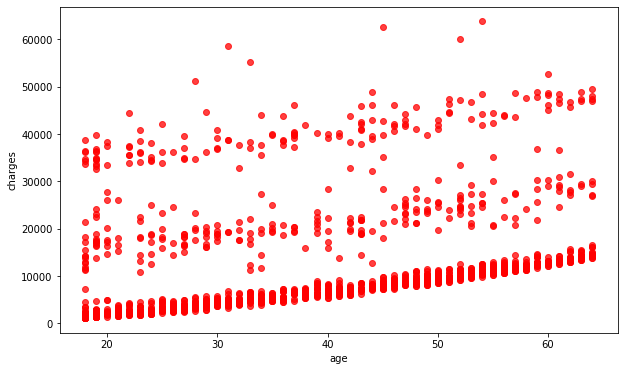

In [4]:
a = str(input('Введите первое значение: '))
b = str(input('Введите второе значение: '))

plt.figure(figsize=(10, 6))

plt.scatter(data[a],
            data[b],
            alpha=0.75,
            color='red')
plt.xlabel(a)
plt.ylabel(b)

# ПОДГОТОВКА ДАННЫХ КЛАСТЕРИЗАЦИИ

In [5]:
# загрузка библиотеки препроцесинга данных
from sklearn import preprocessing
dataNorm = preprocessing.scale(data)

In [6]:
# Вычислим расстояния между каждым набором данных,
# т.е. строками массива data_for_clust
data_dist = pdist(dataNorm, 'euclidean')

# Главная функция иерархической кластеризии
# Объедение элементов в кластера и сохранение в 
# специальной переменной (используется ниже для визуализации 
# и выделения количества кластеров
data_linkage = linkage(data_dist, method='average')

In [7]:
#функция построения дендрограмм
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

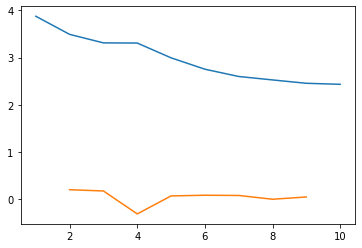

clusters: 2


In [8]:
# Метод локтя. Позволячет оценить оптимальное количество сегментов.
# Показывает сумму внутри групповых вариаций
last = data_linkage[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2 
print("clusters:", k)

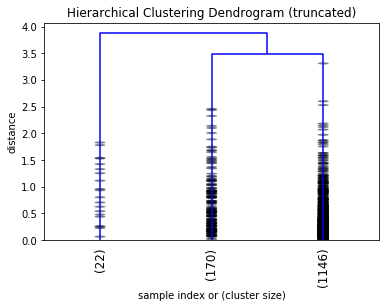

In [9]:
#nCluster - количество кластеров
nCluster=3

#строим дендрограмму 
fancy_dendrogram(
    data_linkage,
    truncate_mode='lastp',
    p=nCluster, 
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
)
plt.show()

## МЕТОД 1
## Иерархическая кластеризация

In [10]:
#импортируем дополнительную библиотеку 
from scipy.cluster.hierarchy import fcluster
max_d = 50 #максимальное расстояние, можно изменять
# находим количество кластеров, между которыми растояние более max_d
clusters = fcluster(data_linkage, max_d, criterion='distance')
clusters

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

In [11]:
k=3 #заданное количество кластеров. Можно менять
clusters=fcluster(data_linkage, k, criterion='maxclust')
clusters

array([3, 3, 3, ..., 3, 3, 3], dtype=int32)

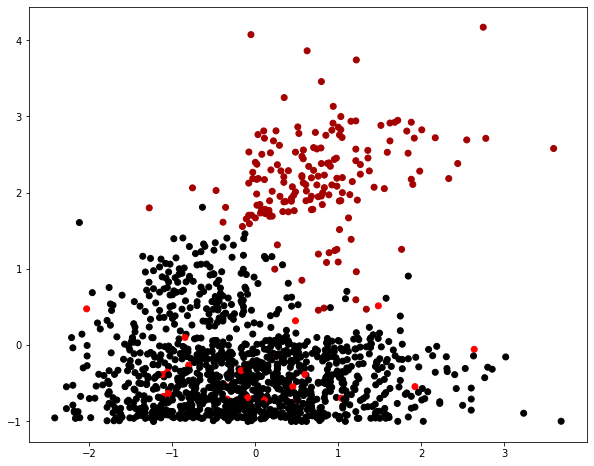

In [12]:
# рисуем график. Выбираем лучшее с точки зрения разбиения.
plt.figure(figsize=(10, 8))
# изменяя номеря сечений, можем выводить распределения в любых осях
plt.scatter(dataNorm[:,1], dataNorm[:,3], c=clusters, cmap='flag') 
plt.show()

In [13]:
# к оригинальным данным добавляем 
dataI=data
dataI['cluster_no']=clusters
# Имя и название файла ниже можно изменять. Если файл не существует, то будем создан
# sheet_name - имя листа на который будет записан результат
writer = pd.ExcelWriter('Иерархическая кластеризация.xlsx')
dataI.to_excel(writer,'IER')
writer.save()

## МЕТОД 2
## Кластеризация методом k-means

In [16]:
# n_clusters - количество кластеров
km = KMeans(n_clusters=3).fit(dataNorm)

In [17]:
# выведем полученное распределение по кластерам
km.labels_ +1

array([2, 2, 2, ..., 2, 2, 3])

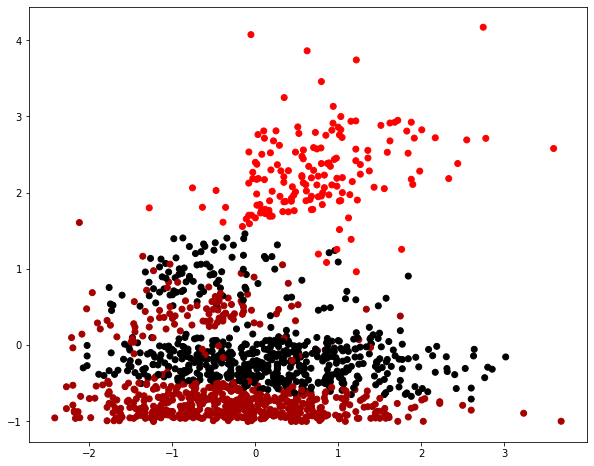

In [18]:
plt.figure(figsize=(10, 8))
plt.scatter(dataNorm[:,1], dataNorm[:,3], c=km.labels_, cmap='flag')
plt.show()

In [21]:
# к оригинальным данным добавляем номера кластеров
dataK=data
dataK['group_no']=clusters
# Имя и название файла ниже можно изменять. Если файл не существует, то будем создан
writer = pd.ExcelWriter('k-средних.xlsx')
dataK.to_excel(writer,'KMeans')
writer.save()

## МЕТОД 3
## Кластеризация на основе плотности DBSCAN

In [22]:
#загрузка библиотек
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

In [23]:
#определение модели
dbscan = DBSCAN()

In [24]:
#обучение
dbscan.fit(data)

DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

In [25]:
#уменьшение размерности при помощи метода главных компонентов
pca = PCA(n_components=2).fit(data)
pca_2d = pca.transform(data)

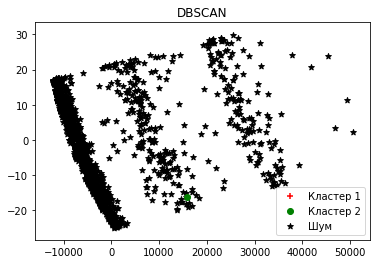

In [26]:
#построение графика в соответствии с тремя классами
for i in range(0, pca_2d.shape[0]):
    if dbscan.labels_[i] == 0:
        c1 = plt.scatter(pca_2d[i, 0], pca_2d[i, 1], c='r', marker='+')
    elif dbscan.labels_[i] == 1:
        c2 = plt.scatter(pca_2d[i, 0], pca_2d[i, 1], c='g', marker='o')
    elif dbscan.labels_[i] == -1:
        c3 = plt.scatter(pca_2d[i, 0], pca_2d[i, 1], c='black', marker='*')
c1 = plt.scatter(pca_2d[i, 0], pca_2d[i, 1], c='r', marker='+')
c2 = plt.scatter(pca_2d[i, 0], pca_2d[i, 1], c='g', marker='o')
plt.legend([c1, c2, c3], ['Кластер 1', 'Кластер 2', 'Шум'])
plt.title('DBSCAN')
plt.show()